# LGM-VIP Data Science Internship Programme
## Beginner Level Task-3
## Music Recommendation
### Name  : Daksh Pathak

**-> Problem Description**

Given set of features we have to predict wether the user would like to listen the recommneded song or not.

**-> Machine Learning problem formulation**

In this task, we have to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered.
 If there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, its target is marked 1, and 0 otherwise in the training set.


# **-> Data overview**

Source : https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data

Total 5 data files are given

**train.csv : 

**test.csv : 

**members.csv: 

**song_extra_info.csv : 


# ***We are given two classes 0/1 hence we can map this problem as a binary classification problem.***

**-> Performance metric**

There is no clear instructions about performance metric so we will consider AUC.

In [ ]:
# Importing basic libraries
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import gc
import lightgbm as lgb
from xgboost import XGBClassifier

# Reading required files from their respective paths

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
songs = pd.read_csv('songs.csv')
members = pd.read_csv('members.csv')
song_extra_info = pd.read_csv('song_extra_info.csv')

Now , we are printing the shape and features of  each file , for a better understanding .

In [ ]:
print('Shape of train file is : ', train.shape)
print('Shape of test file is : ', test.shape)
print('Shape of songs file is : ', songs.shape)
print('Shape of members file is : ', members.shape)
print('Shape of songs_extra_info file is : ', song_extra_info.shape)

Shape of train file is :  (211170, 6)
Shape of test file is :  (216746, 6)
Shape of songs file is :  (297905, 7)
Shape of members file is :  (34403, 7)
Shape of songs_extra_info file is :  (381354, 3)


In [ ]:
print('Features of train : ', train.columns)
print('Features of test :', test.columns)
print('Features of songs : ', songs.columns)
print('Features of members : ', members.columns)
print('Features of songs_extra_info : ', song_extra_info.columns)

Features of train :  Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target'],
      dtype='object')
Features of test : Index(['id', 'msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type'],
      dtype='object')
Features of songs :  Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')
Features of members :  Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date'],
      dtype='object')
Features of songs_extra_info :  Index(['song_id', 'name', 'isrc'], dtype='object')


#**Analysis of data in Train.csv**

Here , We will basically analyze each and every feature from the files with respect to the target.


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211170 entries, 0 to 211169
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   msno                211170 non-null  object 
 1   song_id             211169 non-null  object 
 2   source_system_tab   210579 non-null  object 
 3   source_screen_name  201276 non-null  object 
 4   source_type         210799 non-null  object 
 5   target              211169 non-null  float64
dtypes: float64(1), object(5)
memory usage: 9.7+ MB


In [ ]:
def count_plot(data, x, hue, type):
  '''Function to plot histograms with respect to argument type (category/target)'''
  plt.figure(figsize=(18,15))
  sns.set(font_scale=2)
  sns.countplot(x=x, hue=hue, data=data)
  plt.xlabel(x,fontsize=30)
  plt.ylabel('count',fontsize=30)
  plt.xticks(rotation='90')
  plt.title('Count plot for {0} in {1} data'.format(x, type),fontsize=30)
  plt.tight_layout()

# Function to plot histograms for categories

In [ ]:
def count_plot_function(data, x):
  
  plt.figure(figsize=(18,15))
  sns.set(font_scale=2)
  sns.countplot(x=x, data=data)
  plt.xlabel(x,fontsize=30)
  plt.ylabel('count',fontsize=30)
  plt.xticks(rotation='90')
  plt.title('Count plot',fontsize=30)
  plt.tight_layout()

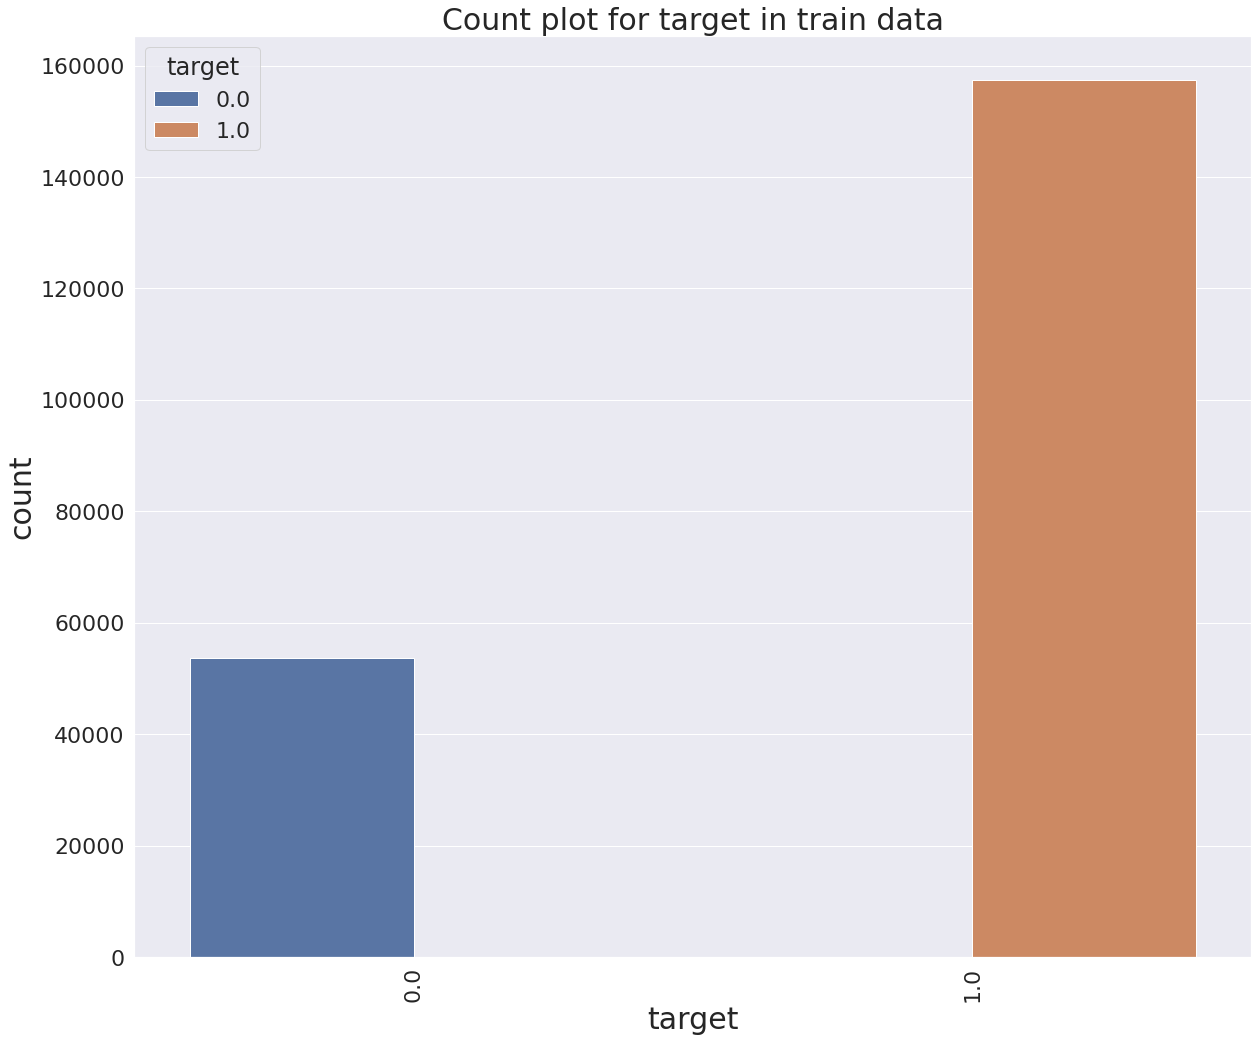

In [ ]:
count_plot(train, 'target', 'target', 'train')

In [ ]:
print('Data for label 1 : {:.4f}%'.format(train['target'].value_counts()[0]/train.shape[0] * 100))
print('Data for label 0 : {:.4f}%'.format(train['target'].value_counts()[1]/train.shape[0] * 100))

Data for label 1 : 25.4127%
Data for label 0 : 74.5868%



Label-1 data is around 29.9% and 

label-0 data is around 70.094%

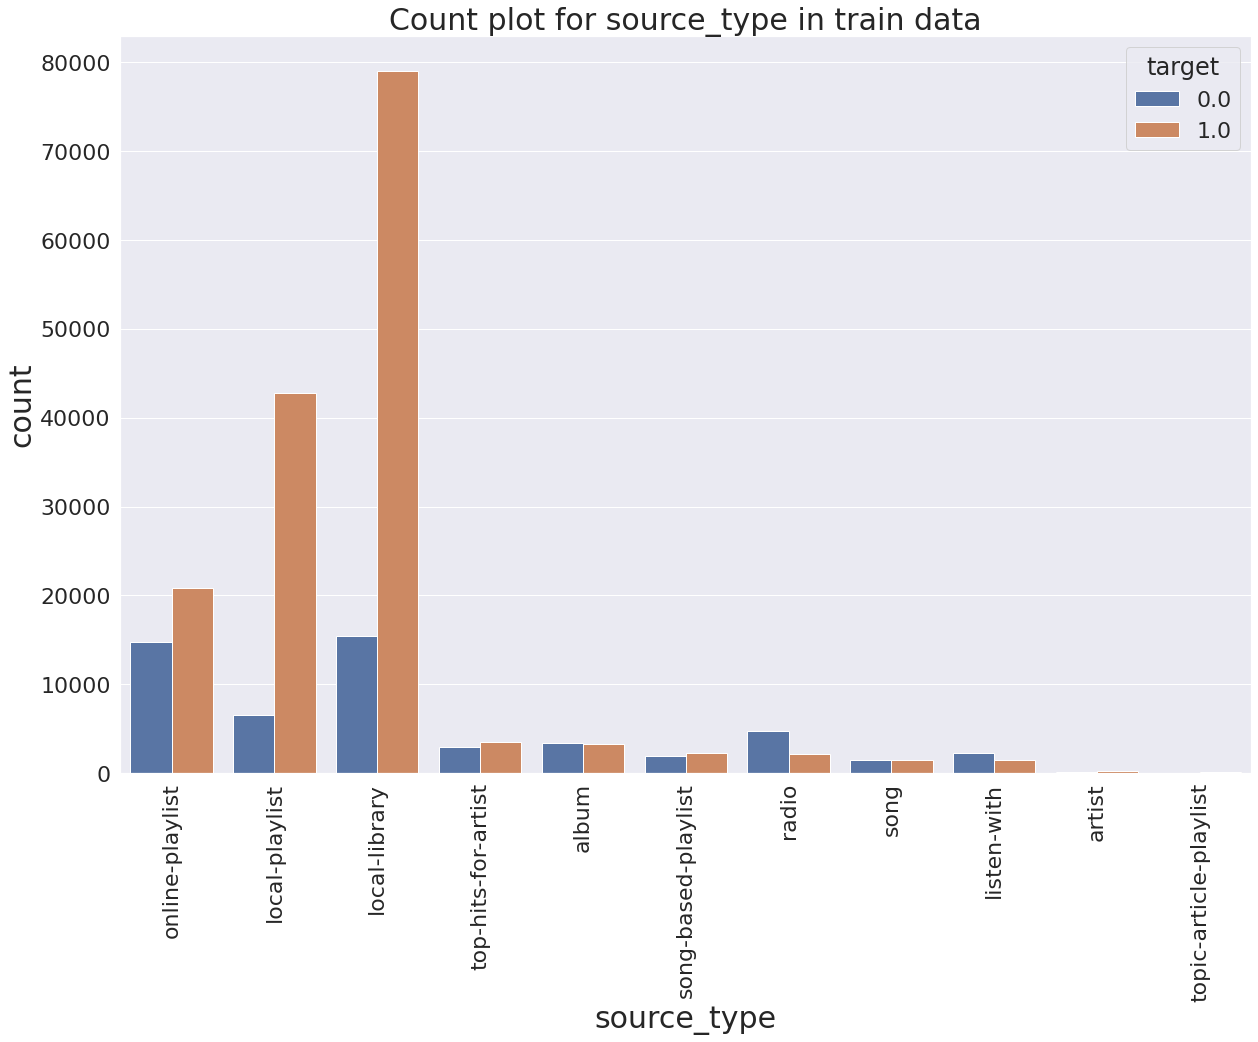

In [ ]:
count_plot(train, 'source_type', 'target', 'train')

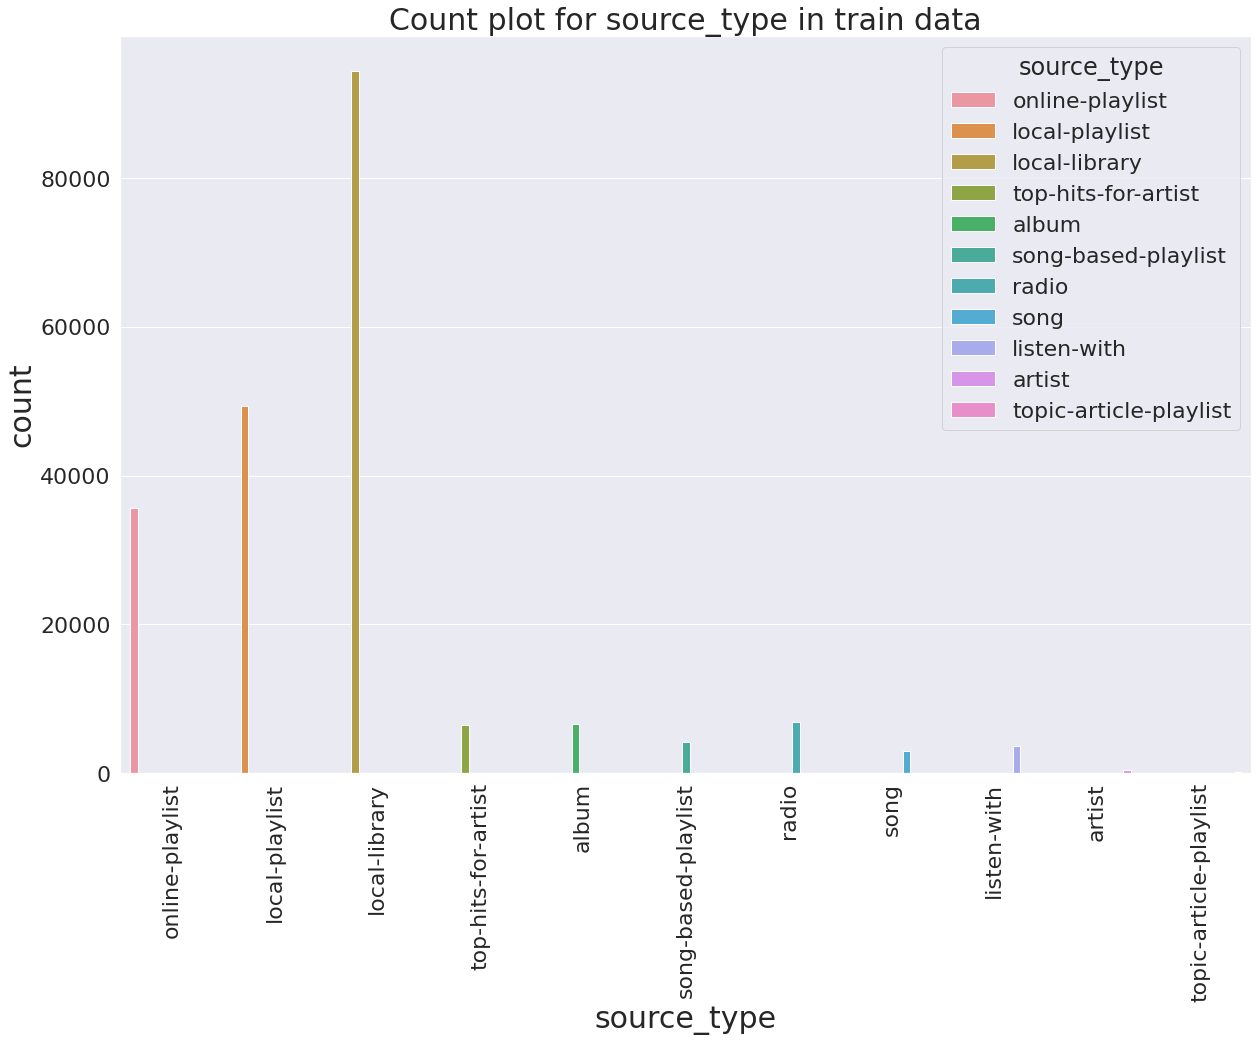

In [ ]:
count_plot(train, 'source_type', 'source_type', 'train')

source_type basically describes the entry point i.e  a user first plays music on mobile apps.

From the above plot it is clear that, most of the users starts playing songs via their local-library, online-playlist or local-playlist.

People don't seem to start listening music with artist or daily-playlist.

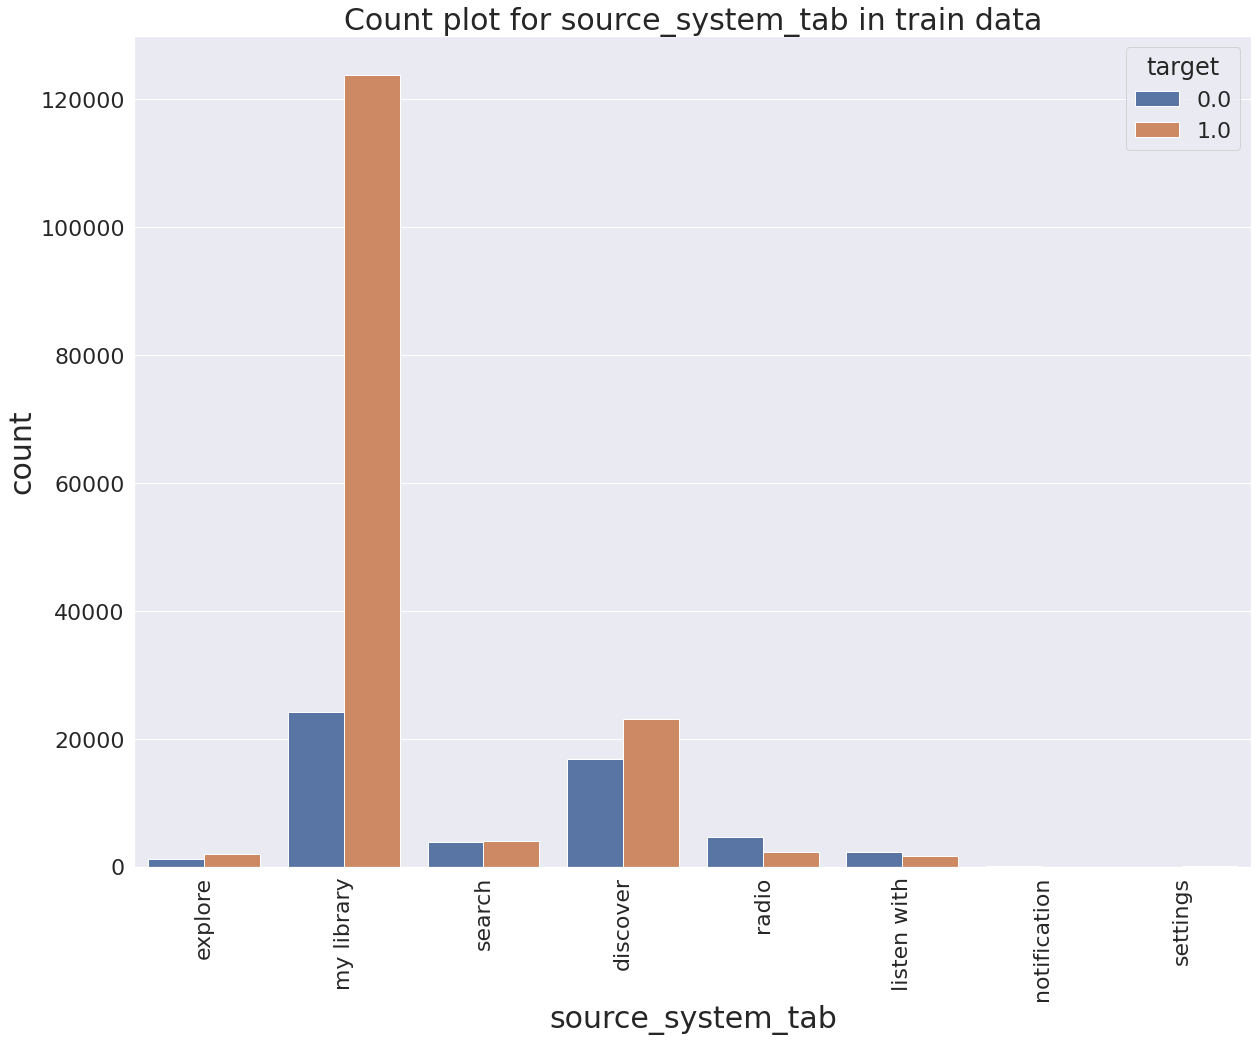

In [ ]:
count_plot(train, 'source_system_tab', 'target', 'train')

source_system_tab describes the name of the tab where the event was triggered. 


The above plot makes it clear that people repeat songs from their library or discover tabs.

People are not interested to repeat songs from notifications or settings tab .

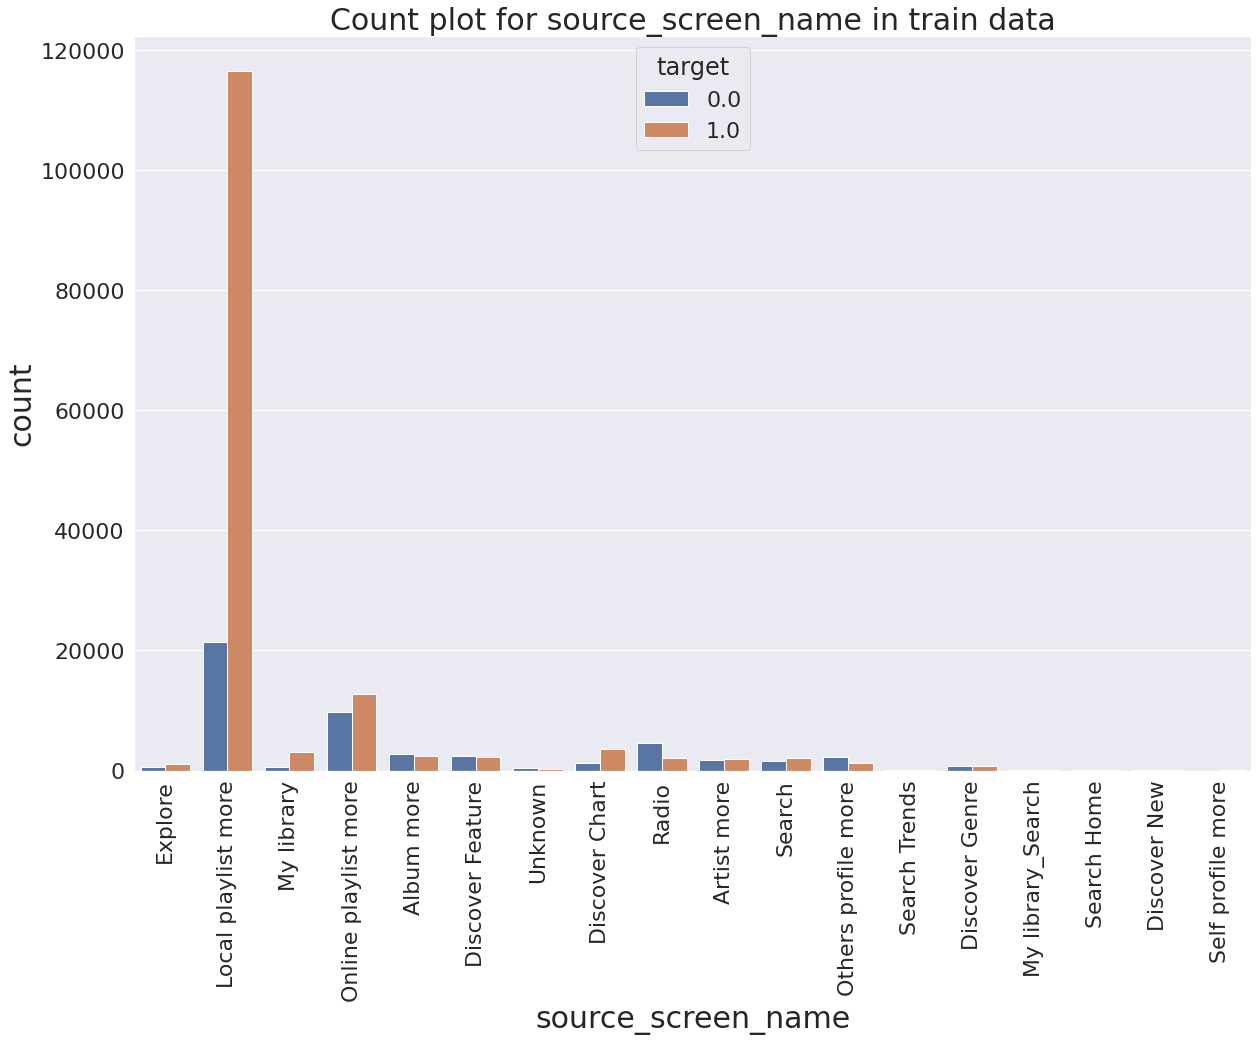

In [ ]:
count_plot(train, 'source_screen_name', 'target', 'train')

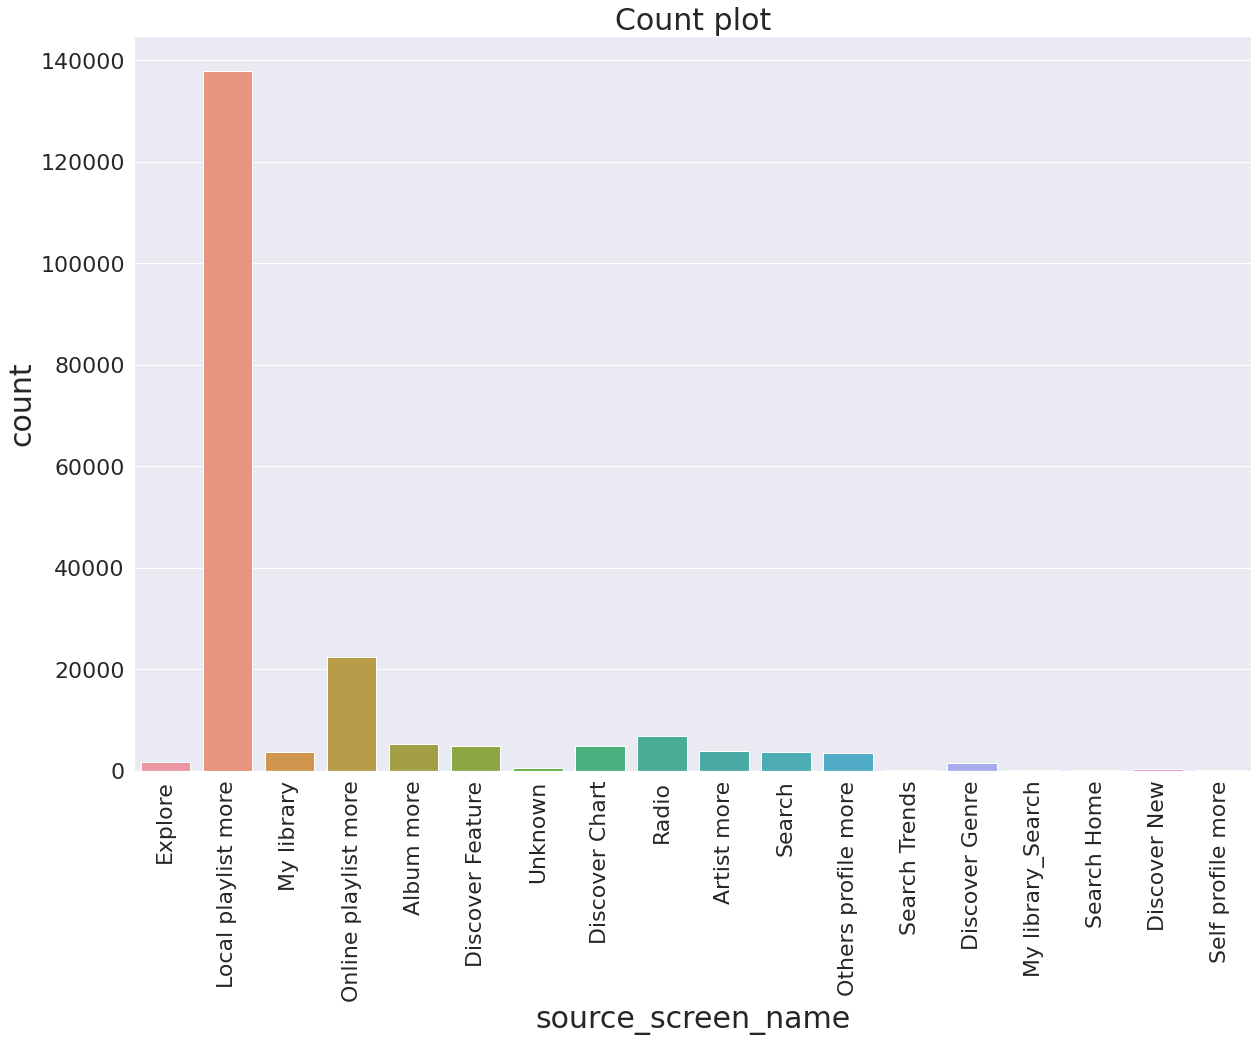

In [ ]:
count_plot_function(train, 'source_screen_name')

source_screen_name is nothing but the  the name of the layout a user sees.

The above plot depicts that most of the users prefer local_playlist or online_playlist_more as their favourite layouts.

# **Analysis of data in Members.csv file**

In [ ]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


# def count_plot_function(data, x):
  '''Function to plot histograms for categories'''
  plt.figure(figsize=(18,15))
  sns.set(font_scale=2)
  sns.countplot(x=x, data=data)
  plt.xlabel(x,fontsize=30)
  plt.ylabel('count',fontsize=30)
  plt.xticks(rotation='90')
  plt.title('Count plot',fontsize=30)
  plt.tight_layout()

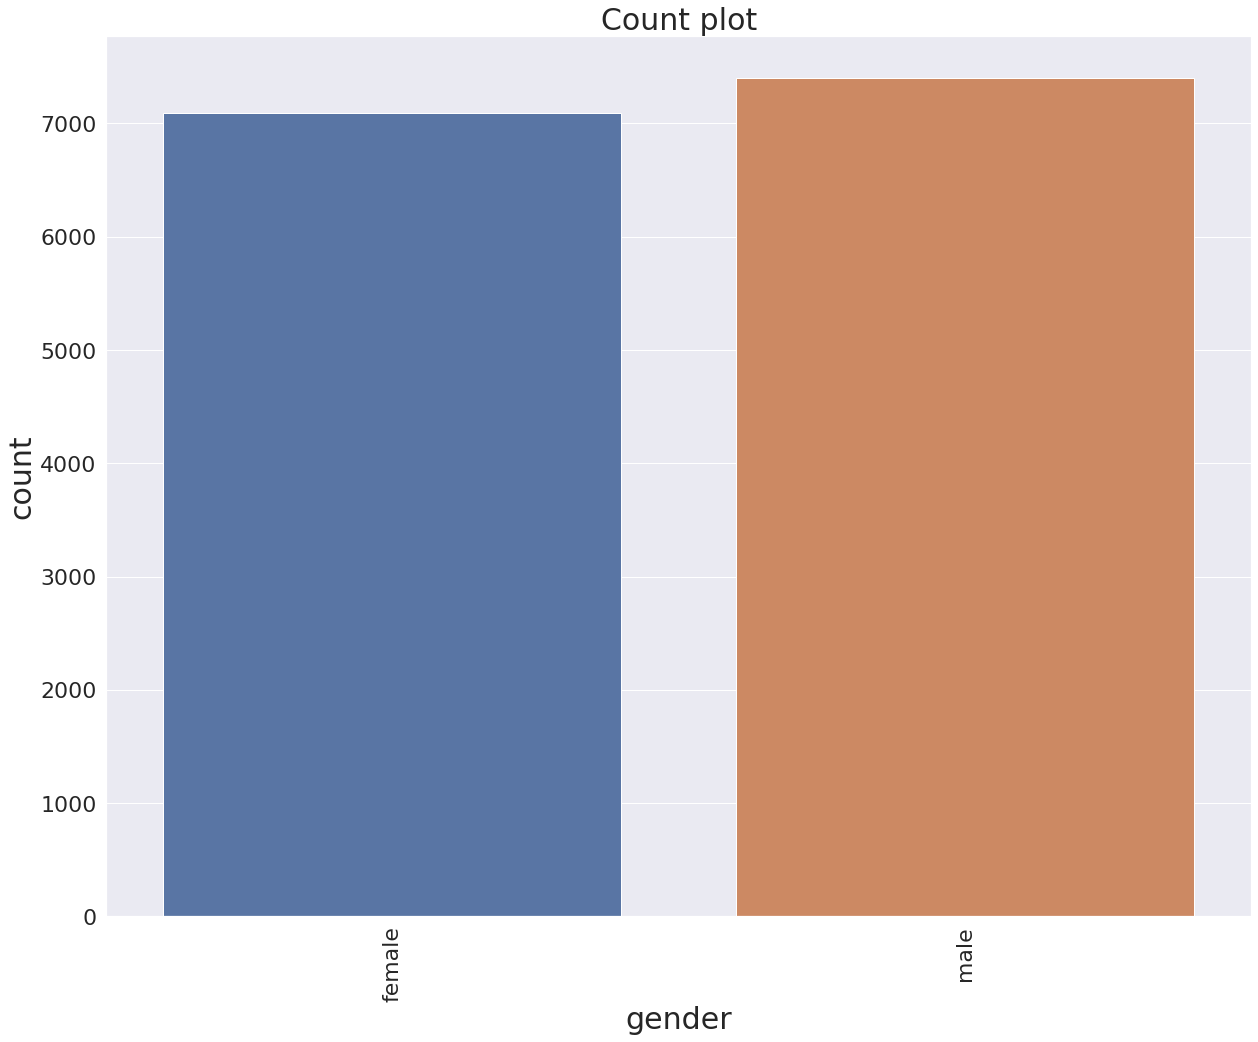

In [ ]:
count_plot_function(members, 'gender')

Form the above plot , both male and female users prefer to listen songs equally.


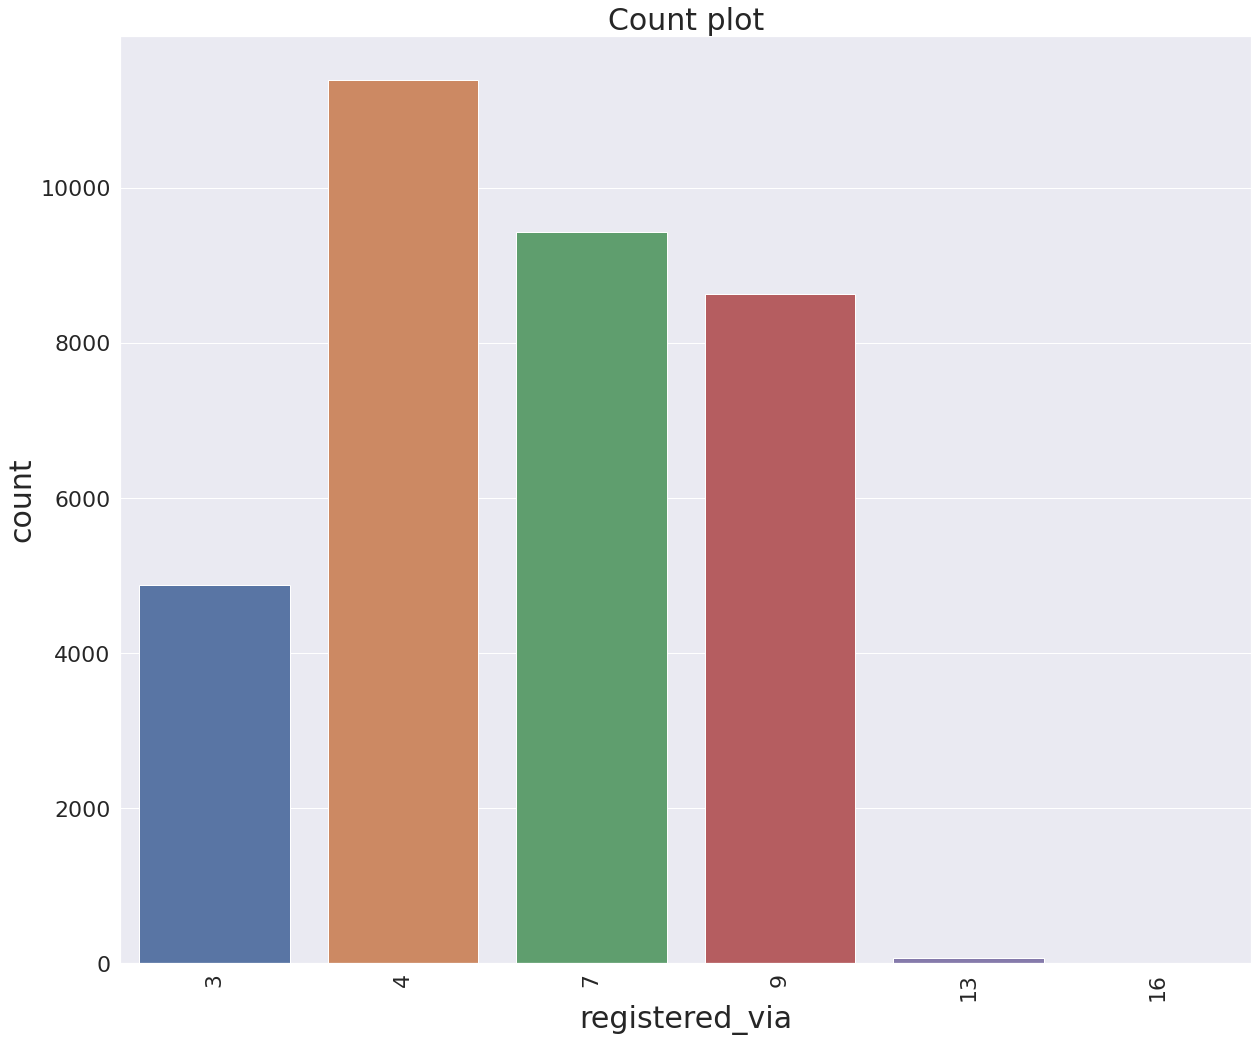

In [ ]:
count_plot_function(members, 'registered_via')

Below is the data obtained from the above plot :

Most of the registrations happened via method '4', '7' and '9'.

Very Few uses have registered theirselves via '13' and '16' methods.

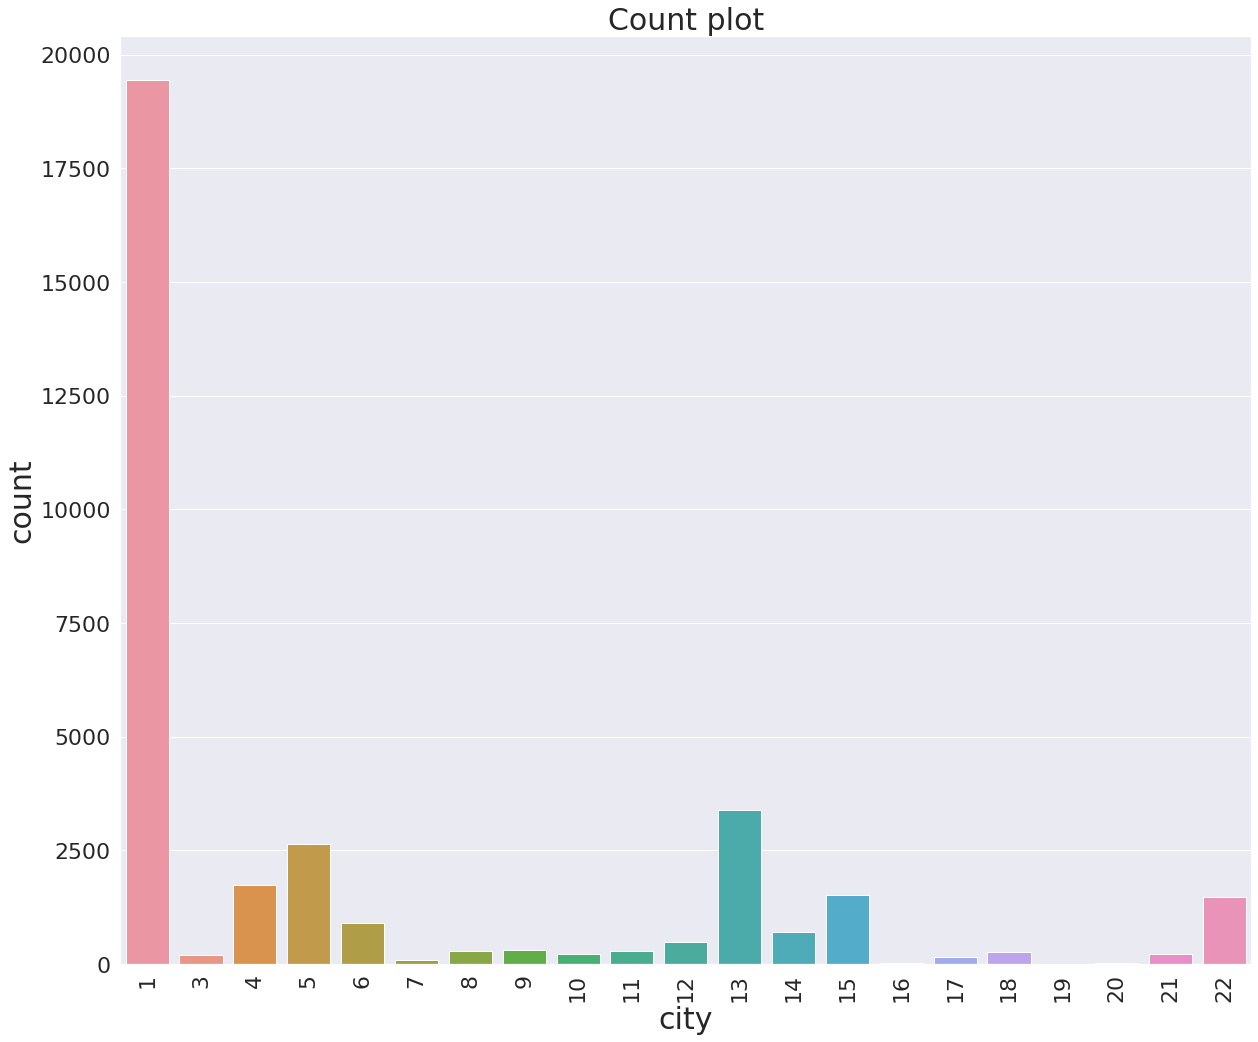

In [ ]:
count_plot_function(members, 'city')

From the above plot , we can derive the following observations: 

Most of the people who used to listen songs are from '1'- labelled city.

Some cities have very few people who prefer listening music via this music app.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF for registration')

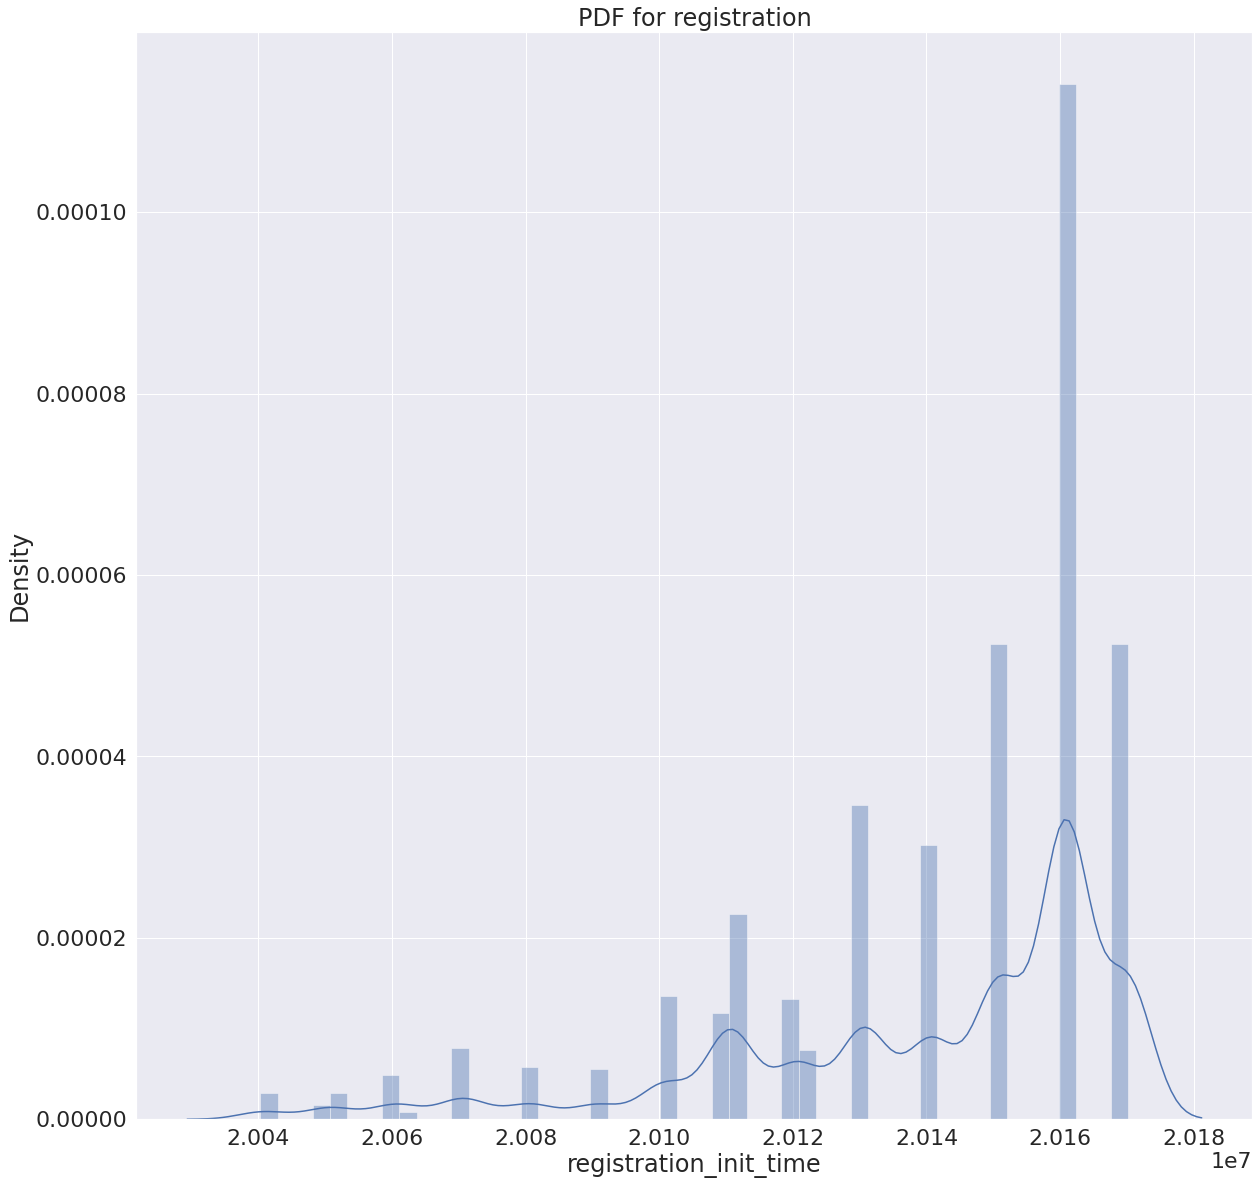

In [ ]:
plt.figure(figsize = (20, 20)) 
sns.distplot(members.registration_init_time)
sns.set(font_scale=2)
plt.title('PDF for registration')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF for registration')

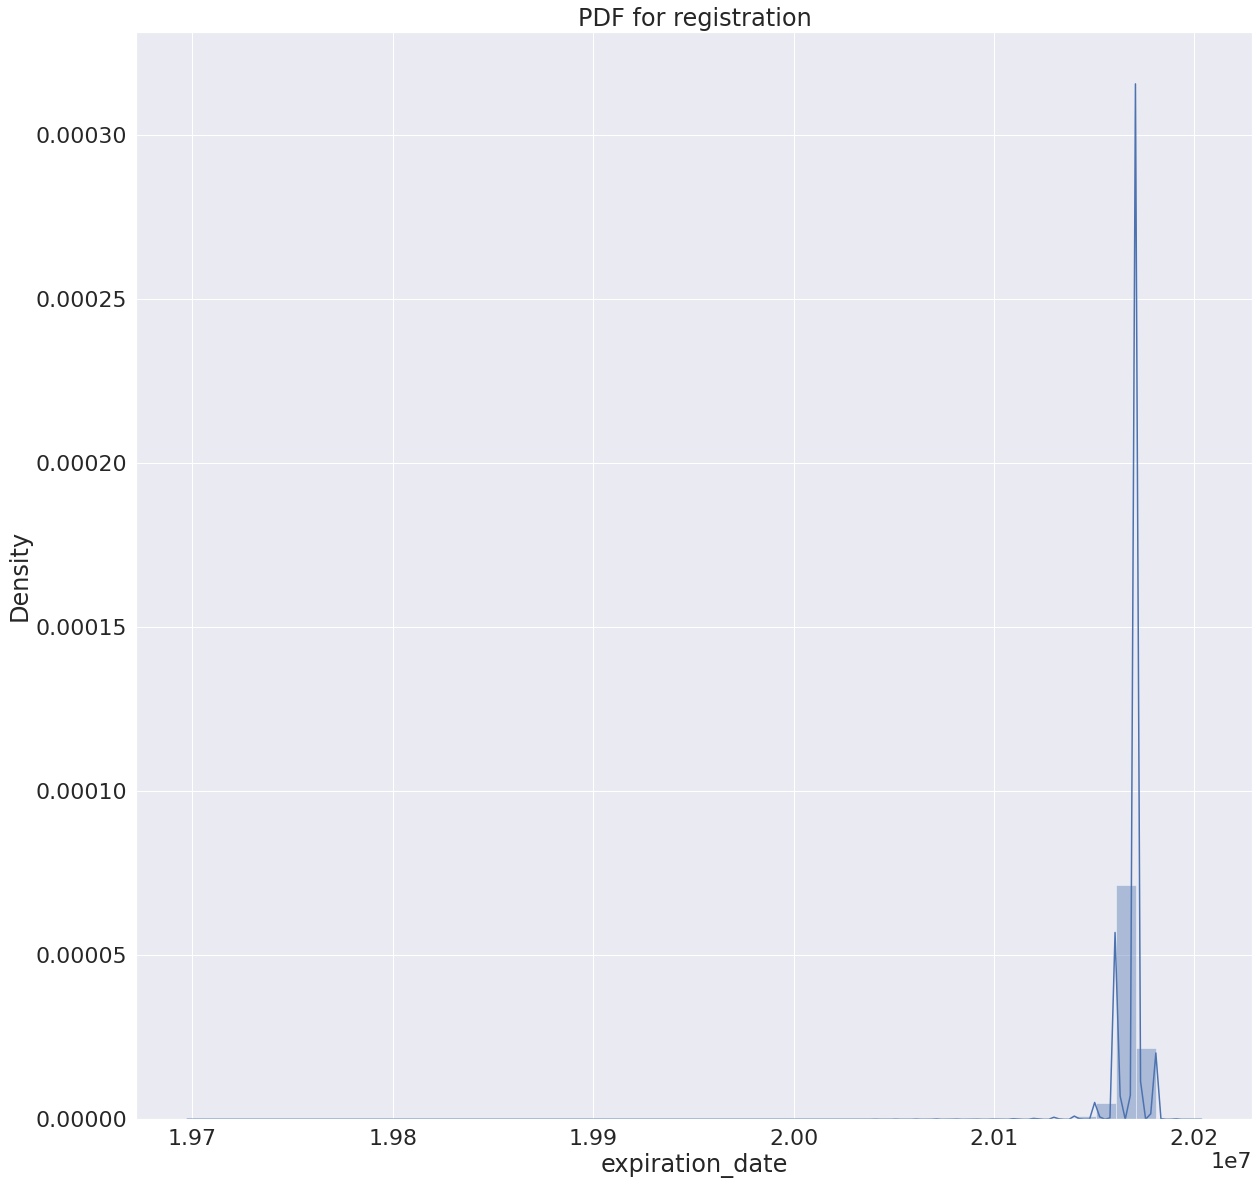

In [ ]:
plt.figure(figsize = (20, 20)) 
sns.distplot(members['expiration_date'])
sns.set(font_scale=2)
plt.title('PDF for registration')

In [ ]:
members.bd.unique()

array([   0,   43,   28,   33,   20,   30,   29,   26,   25,   21,   22,
         16,   23,   37,   18,   19,   51,   24,   17,   45,   36,   57,
         27,   34,   32,   15,   48,   50,   54,   47,   35,   46,   31,
         14,   41,   59,    2,   40,   38,   55,   39,   73,   49,   44,
        103,   52,   70,   42,   65,   56,  101,   58,   53,   64,   63,
         76,   66,   97,    3,   72,   67,   62,   61,  105,   60,   13,
         90,   12,   68,  131,   74,   89,  931,  -38,  144,   85,  112,
         96,   11,  102,   83, 1051,   87,    7,   95,  -43,  111,   93,
          5,   78, 1030,  106,  107,   82,   10])

In [ ]:
def plot_pdf_cdf(x, flag):
  '''Function to plot pdf and cdf'''
  plt.figure(figsize = (15, 10)) 
  kwargs = {'cumulative': True}
  if flag:
    sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)
    plt.title('CDF for age')
  else:
    sns.distplot(x)
    plt.title('PDF for age')
  sns.set(font_scale=2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


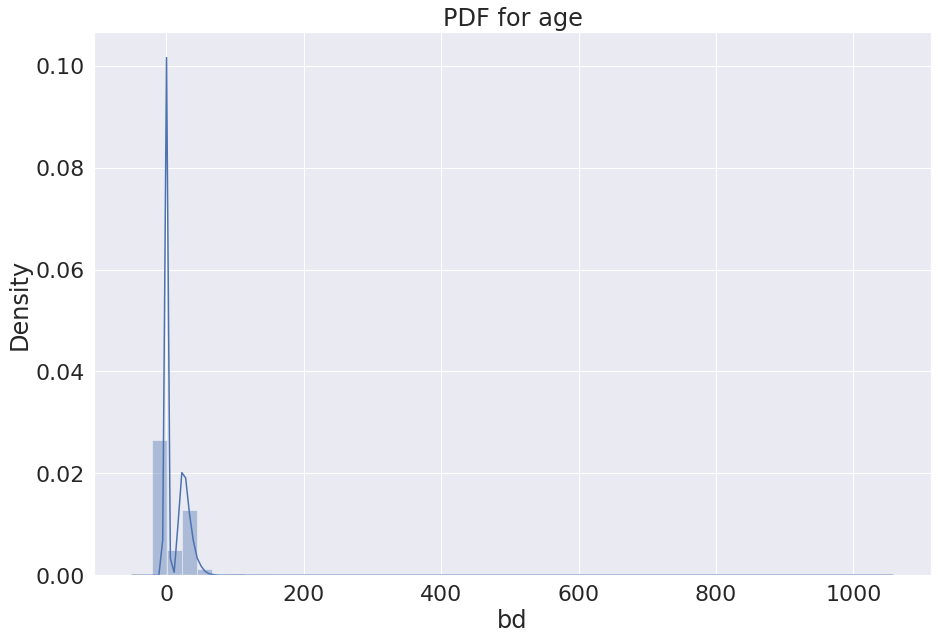

In [ ]:
plot_pdf_cdf(members['bd'], False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


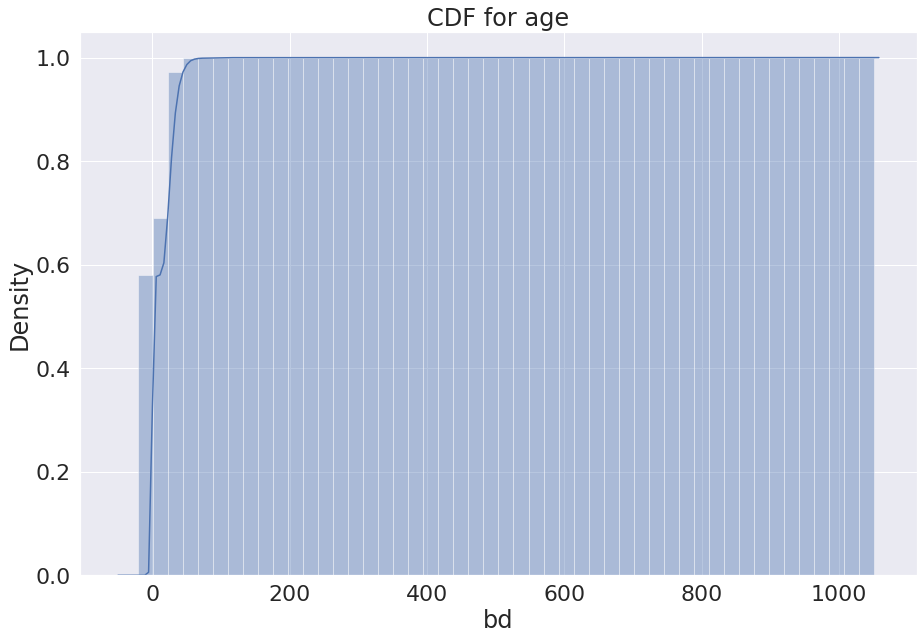

In [ ]:
plot_pdf_cdf(members['bd'], True)

In [ ]:
np.percentile(members['bd'].values, 98)

47.0

It is observed that 

98th percentile user is of 47 age.

This means that most of the user are below the age of 50.

We also can observe that there are also some outliers like 1030, -38, -43, 1051, etc. As age cannot be negative value or more than 1000 .

# **Analysis of data in songs.csv**

We have two files which contains information about songs i.e :

songs

song_extra_info

so let's merge two files and analyze features in details.

In [ ]:
song_extra_info

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001
...,...,...,...
381349,w2ZFWC5c49JPpuXZUUJ0IYEy0XGF3D9BexHZ1KmGAd8=,Sing| Sing| Sing,USSP30800261
381350,Yt7+limf1Ore26Xm4Usw7ECrd+cFWwK56dAaeuhmLH0=,Anu,USDBY1500025
381351,V9lHyP8lPGn04MWY0dLd4Ku9Xqx8UR14cXb2xUk9YDw=,Little Bo Beep,GBPW41515815
381352,X0Ep+wfkhWw21IXtsZmxqaS9GBHwmxzl02/laNbSOag=,沙悟嬢,JPP321600431


In [ ]:
songs_all_info = songs.merge(song_extra_info, on='song_id')

In [ ]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

songs_all_info['song_year'] = songs_all_info['isrc'].apply(isrc_to_year)

In [ ]:
songs_all_info['language'].unique()

array([ 3., 31., 52., 17., 10., -1., 24., 45., 59., 38.])

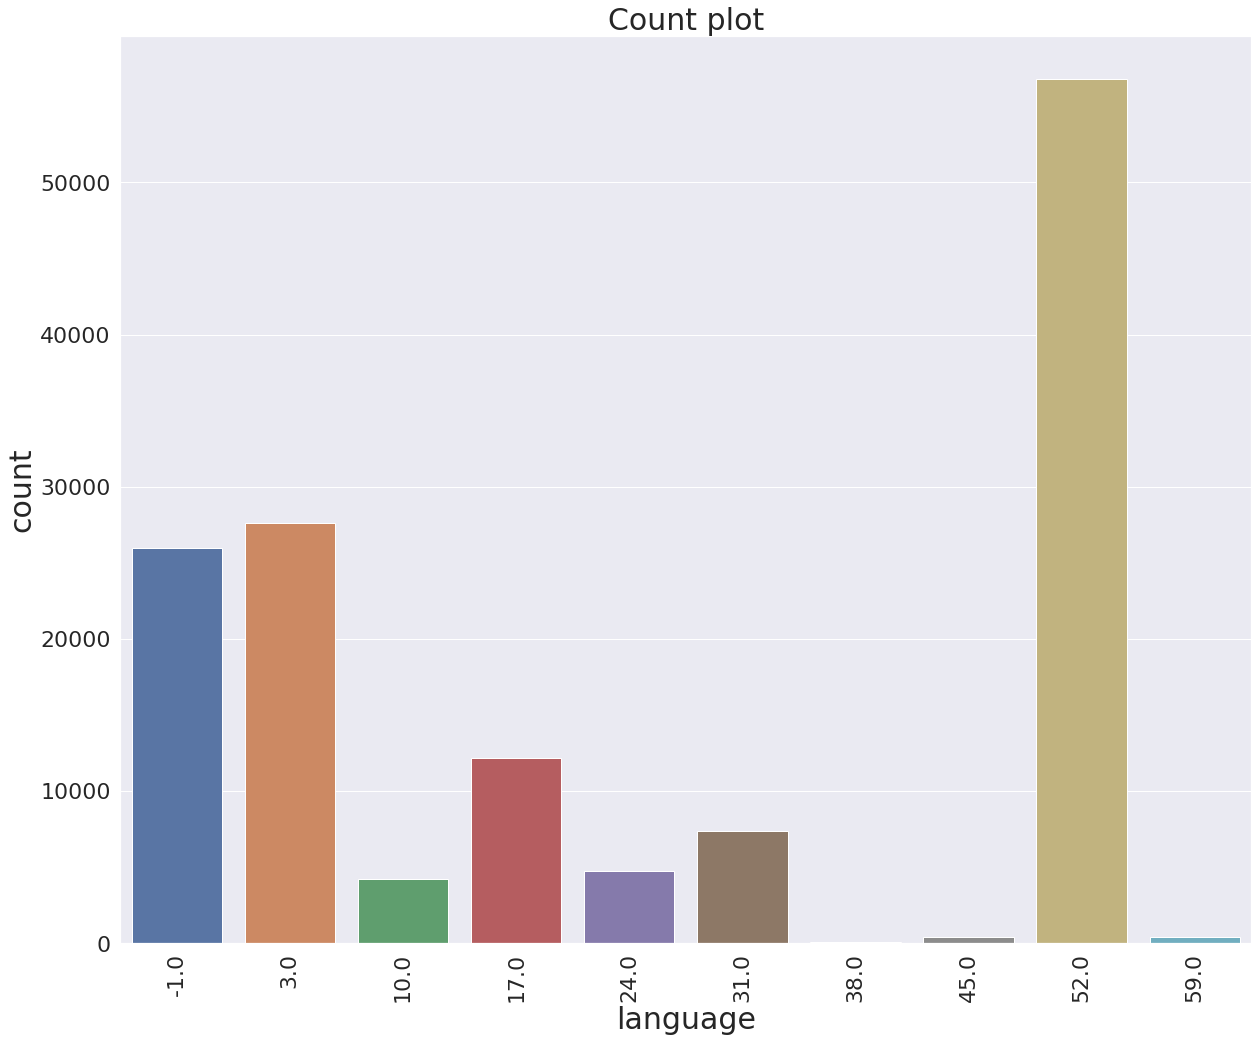

In [ ]:
count_plot_function(songs_all_info, 'language')

From the above plot it is evident thet Users prefer to listen songs from '52' and '-1' language.

# **Merging of data and analysis**

**Missing values:**

We will check % of missing values in each column of dataframe.

In [ ]:
def check_missing_values(df):
  '''Function to check missing values in df'''
  for col in df.columns:
    nan_count = df[col].isnull().sum()
    total = df.shape[0]
    percentage = nan_count/total * 100
    print(col, 'has {:.2f}% missing values'.format(percentage))

In [ ]:
print('Missing values analysis for train data')
check_missing_values(train)

Missing values analysis for train data
msno has 0.00% missing values
song_id has 0.00% missing values
source_system_tab has 0.28% missing values
source_screen_name has 4.69% missing values
source_type has 0.18% missing values
target has 0.00% missing values


In [ ]:
print('Missing values analysis for members data')
check_missing_values(members)

Missing values analysis for members data
msno has 0.00% missing values
city has 0.00% missing values
bd has 0.00% missing values
gender has 57.85% missing values
registered_via has 0.00% missing values
registration_init_time has 0.00% missing values
expiration_date has 0.00% missing values


In [ ]:
print('Missing values analysis for songs data')
check_missing_values(songs)

Missing values analysis for songs data
song_id has 0.00% missing values
song_length has 0.00% missing values
genre_ids has 2.39% missing values
artist_name has 0.00% missing values
composer has 43.45% missing values
lyricist has 76.35% missing values
language has 0.00% missing values


In [ ]:
print('Missing values analysis for songs_all_info data')
check_missing_values(songs_all_info)

Missing values analysis for songs_all_info data
song_id has 0.00% missing values
song_length has 0.00% missing values
genre_ids has 1.62% missing values
artist_name has 0.00% missing values
composer has 41.98% missing values
lyricist has 72.05% missing values
language has 0.00% missing values
name has 0.00% missing values
isrc has 14.69% missing values
song_year has 14.69% missing values


We can see that train data has over all missing values below 5%.

In members data 'gender' feature has 57.85% missing values.

Songs has 'composer' and 'lyricist' features which contains 46% and 83% missing values respectively.

In [ ]:
train_members = pd.merge(train, members, on='msno', how='left')
train_merged = pd.merge(train_members, songs_all_info, on='song_id', how='left')

In [ ]:
test_members = pd.merge(test, members, on='msno', how='left')
test_merged = pd.merge(test_members, songs_all_info, on='song_id', how='left')

In [ ]:
del train_members
del test_members

In [ ]:
check_missing_values(train_merged)

msno has 0.00% missing values
song_id has 0.00% missing values
source_system_tab has 0.28% missing values
source_screen_name has 4.69% missing values
source_type has 0.18% missing values
target has 0.00% missing values
city has 0.00% missing values
bd has 0.00% missing values
gender has 39.84% missing values
registered_via has 0.00% missing values
registration_init_time has 0.00% missing values
expiration_date has 0.00% missing values
song_length has 52.76% missing values
genre_ids has 53.38% missing values
artist_name has 52.76% missing values
composer has 62.68% missing values
lyricist has 71.68% missing values
language has 52.76% missing values
name has 52.76% missing values
isrc has 56.64% missing values
song_year has 56.64% missing values


After merging we can say that, 'gender' feature has 40%, 'composer' has 23% and 'lyricist' has 55% missing values.



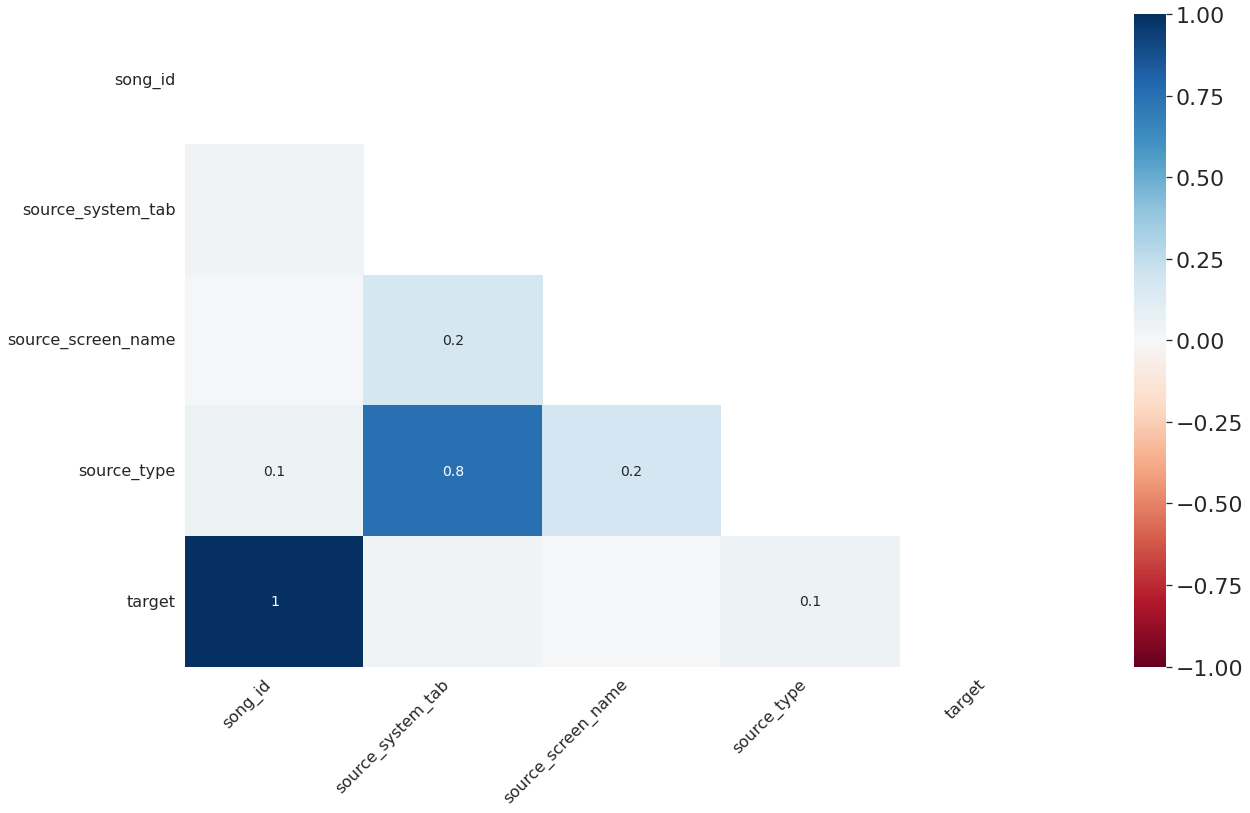

In [ ]:
msno.heatmap(train)

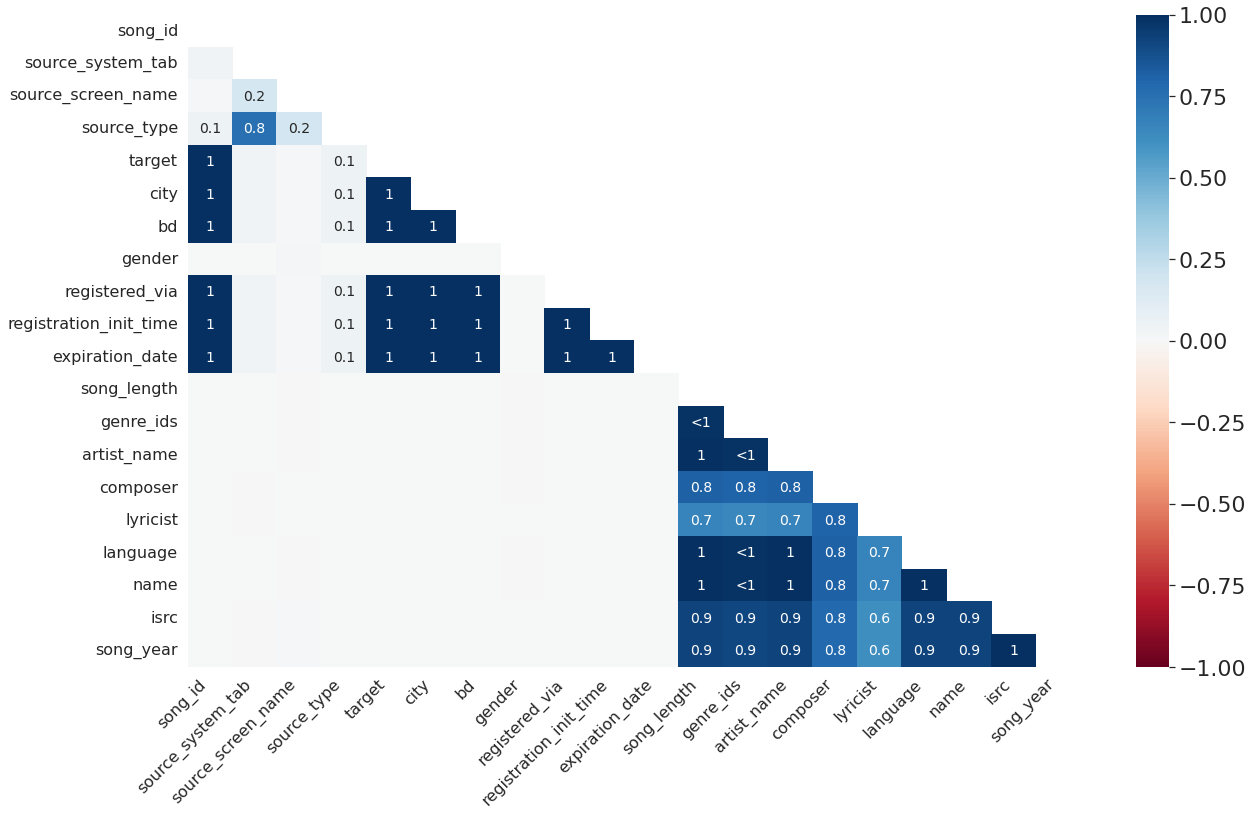

In [ ]:
msno.heatmap(train_merged)


From the above heatmap we can say that, song length is depends on artist and the language in which it is made.


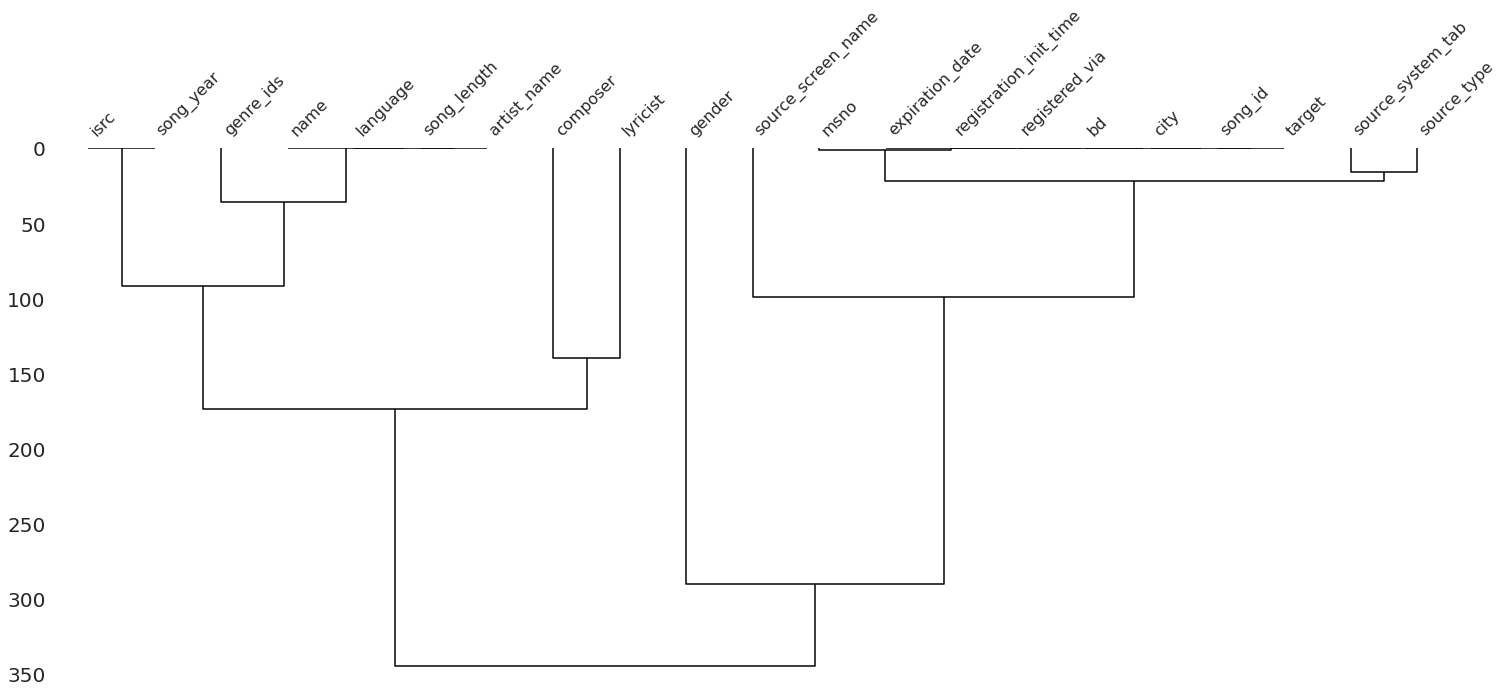

In [ ]:
msno.dendrogram(train_merged)

A strong nullity correlation here we can see:

source_system_tab -> source_type

composer -> lyricst

lanugage -> song_length, artist_name, name

isrc -> song_year



# Feature engineering

**Tasks performed here :**

We have train, test, members, songs and songs_extra_info files.

We will extract individual independent features from members, songs and songs_extra.

We will extract dependent features on train and val data after splitting to avoid data leakage problem.

In [ ]:
del train, test, members, songs, song_extra_info

In [ ]:
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc

In [ ]:
data_path = '/content/drive/My Drive/CS-1/Data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
members = pd.read_csv(data_path + 'members.csv')
songs = pd.read_csv(data_path + 'songs.csv')
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

# Splitting data

In [ ]:
# As the data is oredered in chronological order so, we will take 80% train and 20% val data from train data
tr_index = train.shape[0] * 8 // 10

In [ ]:
train_data = train.iloc[:tr_index]
val_data = train.iloc[tr_index:]
print(train_data.shape, val_data.shape, test.shape)


(5901934, 6) (1475484, 6) (2556790, 6)


# Merge data with members, songs and songs_extra





# merge with members
train_members = pd.merge(train_data, members, on='msno', how='left')
val_members = pd.merge(val_data, members, on='msno', how='left')
test_members = pd.merge(test, members, on='msno', how='left')

In [ ]:
songs_all = pd.merge(songs, songs_extra, on='song_id', how='left')

In [ ]:
# merge with members
train_all = pd.merge(train_members, songs_all, on='song_id', how='left')
val_all = pd.merge(val_members, songs_all, on='song_id', how='left')
test_all = pd.merge(test_members, songs_all, on='song_id', how='left')

In [ ]:
del train_members
del val_members
del test_members
del songs_all

In [ ]:
del train_data
del val_data

In [ ]:
del train, test

# Feature engineering for Members



In [ ]:
def filter_age(x):
  # 98th percentile is 47
  '''Function to fix age value between 0 to 75'''
  if x >= 0 and x <= 75:
    return x
  else:
    return np.nan

train_all['bd'] = train_all['bd'].apply(filter_age)
val_all['bd'] = val_all['bd'].apply(filter_age)
test_all['bd'] = test_all['bd'].apply(filter_age)

# Function to extract features like day, month, year from dates

In [ ]:
def extract_date_fatures(data):
  
  # convert into date format
  data['expiration_date'] = pd.to_datetime(data['expiration_date'], format='%Y%m%d')
  data['registration_init_time'] = pd.to_datetime(data['registration_init_time'], format='%Y%m%d')
  
  # get membership period from registration and expiration dates
  data['membership_days'] = data['expiration_date'].subtract(data['registration_init_time']).dt.days.astype(int)

  # extract year, month and day from dates
  data['registration_year'] = data['registration_init_time'].dt.year
  data['registration_month'] = data['registration_init_time'].dt.month
  data['registration_day'] = data['registration_init_time'].dt.day

  data['expiration_year'] = data['expiration_date'].dt.year
  data['expiration_month'] = data['expiration_date'].dt.month
  data['expiration_day'] = data['expiration_date'].dt.day

  return data

train_all = extract_date_fatures(train_all)
val_all = extract_date_fatures(val_all)
test_all = extract_date_fatures(test_all)

# Feature engineering for songs 



In [ ]:
train_all.tail(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,membership_days,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
5901931,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,b8Ec5KHbhiJc+Aeg4hgVx7mkdk5UlDZyW48Y1OfyqBU=,my library,Local playlist more,local-library,1,1,18.0,female,3,2015-03-21,2017-10-05,214517.0,465,劉思涵 (Koala Liu),王于陞,安立奎,3.0,走在冷風中,TWF711100078,929,2015,3,21,2017,10,5
5901932,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,fwaxN4NL0q27tHQq4VEPCKVTywMIGqImrgRvFLnrVJw=,my library,Local playlist more,local-library,1,1,18.0,female,3,2015-03-21,2017-10-05,283167.0,465,楊培安 (Roger Yang),Du Zhi Wen,Qian Zi,3.0,說好各走五十步,TWA531302103,929,2015,3,21,2017,10,5
5901933,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,yqZjiUmLn/+h6g047I0LNxX3UoS60z3PJacJOFcxFMU=,my library,Local playlist more,local-library,0,1,18.0,female,3,2015-03-21,2017-10-05,204335.0,359,Tegan And Sara,NaN,NaN,52.0,I Was a Fool,USWB11203029,929,2015,3,21,2017,10,5


In [ ]:
train_all.isnull().any()


msno                      False
song_id                   False
source_system_tab          True
source_screen_name         True
source_type                True
target                    False
city                      False
bd                         True
gender                     True
registered_via            False
registration_init_time    False
expiration_date           False
song_length                True
genre_ids                  True
artist_name                True
composer                   True
lyricist                   True
language                   True
name                       True
isrc                       True
membership_days           False
registration_year         False
registration_month        False
registration_day          False
expiration_year           False
expiration_month          False
expiration_day            False
dtype: bool

In [ ]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5901934 entries, 0 to 5901933
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   song_id                 object        
 2   source_system_tab       object        
 3   source_screen_name      object        
 4   source_type             object        
 5   target                  int64         
 6   city                    int64         
 7   bd                      float64       
 8   gender                  object        
 9   registered_via          int64         
 10  registration_init_time  datetime64[ns]
 11  expiration_date         datetime64[ns]
 12  song_length             float64       
 13  genre_ids               object        
 14  artist_name             object        
 15  composer                object        
 16  lyricist                object        
 17  language                float64       
 18  na

# def filling_missing_values(data):
  data['source_system_tab'].fillna('no_system_tab', inplace=True)
  data['source_screen_name'].fillna('no_screen_name', inplace=True)
  data['source_type'].fillna('np_source_type', inplace=True)
  data['bd'].fillna(0, inplace=True)
  data['gender'].fillna('gender_missing', inplace=True)
  data['song_length'].fillna(0, inplace=True)
  data['genre_ids'].fillna(0, inplace=True)
  data['lyricist'].fillna('no_lyricist', inplace=True)
  data['artist_name'].fillna('no_artist_name', inplace=True)
  data['composer'].fillna('no_composer', inplace=True)
  data['language'].fillna('no_language', inplace=True)
  data['name'].fillna('no_name', inplace=True)
  return data

train_all = filling_missing_values(train_all)
val_all = filling_missing_values(val_all)
test_all = filling_missing_values(test_all)

# Feature engineering for genre



In [ ]:
def generate_genre_ids(data):
  '''Function to sepearate each genre_id and count total number of genre_ids'''
  genre_ids_matrix = np.zeros((data.shape[0], 4))

  for i in range(data.shape[0]):
    ids = str(data['genre_ids'].values[i]).split('|')
    if len(ids) > 2:
        genre_ids_matrix[i, 0] = (ids[0])
        genre_ids_matrix[i, 1] = (ids[1])
        genre_ids_matrix[i, 2] = (ids[2])
    elif len(ids) > 1:
        genre_ids_matrix[i, 0] = (ids[0])
        genre_ids_matrix[i, 1] = (ids[1])
    elif len(ids) == 1:
        genre_ids_matrix[i, 0] = (ids[0])
    genre_ids_matrix[i, 3] = len(ids)

  data['first_genre_id'] = genre_ids_matrix[:, 0] # keeps first genre_id
  data['second_genre_id'] = genre_ids_matrix[:, 1] # keeps second genre_id
  data['third_genre_id'] = genre_ids_matrix[:, 2] # keeps third genre_id
  data['genre_ids_count'] = genre_ids_matrix[:, 3] # keeps count of genre_ids
  return data

In [ ]:
train_all = generate_genre_ids(train_all)
val_all = generate_genre_ids(val_all)
test_all = generate_genre_ids(test_all)

We will drop 'composer' and 'lyricist' as they contains higher missing values.

In [ ]:
train_all = train_all.drop(['composer', 'lyricist'], axis=1)
val_all = val_all.drop(['composer', 'lyricist'], axis=1)
test_all = test_all.drop(['composer', 'lyricist'], axis=1)

# Feature engineering for artist



In [ ]:
def calculate_is_featured(data):
  '''Function to check 'feat' in artist field.'''
  data['is_featured'] = data['artist_name'].apply(lambda x: 1 if ' feat' in str(x) else 0).astype(np.int8)
  return data

In [ ]:
train_all = calculate_is_featured(train_all)
val_all = calculate_is_featured(val_all)
test_all = calculate_is_featured(test_all)

In [ ]:
def artist_count(x):
  '''Function to count total number of artists for each song'''
  return x.count('and') + x.count(',') + x.count(' feat') + x.count('&') + 1

def get_first_artist(x):
  '''Function to extract first artist name from more than one artists'''
  if x.count('and') > 0:
    x = x.split('and')[0]
  if x.count(',') > 0:
    x = x.split(',')[0]
  if x.count(' feat') > 0:
    x = x.split(' feat')[0]
  if x.count('&') > 0:
    x = x.split('&')[0]
  return x.strip()

In [ ]:
def calculate_artist_features(data):
  '''Function to execute above both functions'''
  # get artist count 
  data['artist_count'] = data['artist_name'].apply(artist_count).astype(np.int8)
  # get first artist name
  data['first_artist_name'] = data['artist_name'].apply(get_first_artist)
  return data

In [ ]:
train_all = calculate_artist_features(train_all)
val_all = calculate_artist_features(val_all)
test_all = calculate_artist_features(test_all)

# Feature engineering for extra



In [ ]:
def song_lang_boolean(x):
  '''Function to add language boolean feature'''
  if 17.0 == str(x) or 45.0 == str(x):
    return 1
  else:
    return 0
    
mean_song_length = np.mean(train_all['song_length'])
def smaller_song(x):
  '''Function to add song_size boolean feature'''
  if x < mean_song_length:
    return 1
  else:
    return 0

In [ ]:
def calculate_language_features(data):
  data['song_lang_boolean'] = data['language'].apply(song_lang_boolean).astype(np.int8)
  data['song_size_boolean'] = data['song_length'].apply(smaller_song).astype(np.int8)
  return data

In [ ]:
train_all = calculate_language_features(train_all)
val_all = calculate_language_features(val_all)
test_all = calculate_language_features(test_all)

# Feature engineering for songs extra



In [ ]:
def calcualte_songs_features(data):
  '''Function to extract features from isrc.'''
  isrc = data['isrc']
  data['country_code'] = isrc.str.slice(0, 2)
  data['registration_code'] = isrc.str.slice(2, 5)
  data['song_year'] = isrc.str.slice(5, 7).astype(float)
  data['song_year'] = data['song_year'].apply(lambda x: 2000+x if x < 18 else 1900+x)
  data['isrc_missing'] = (data['country_code'] == 0) * 1.0
  return data

In [ ]:
train_all = calcualte_songs_features(train_all)
val_all = calcualte_songs_features(val_all)
test_all = calcualte_songs_features(test_all)

In [ ]:
def filling_missing_isrc_values(data):
  '''Function to fill missing isrc values'''
  data['isrc'].fillna('no_isrc', inplace=True)
  data['country_code'].fillna('no_country_code', inplace=True)
  data['registration_code'].fillna('no_registration_code', inplace=True)
  data['song_year'].fillna('no_song_year', inplace=True)
  return data

train_all = filling_missing_isrc_values(train_all)
val_all = filling_missing_isrc_values(val_all)
test_all = filling_missing_isrc_values(test_all)

In [ ]:
val_all.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'language', 'name', 'isrc', 'membership_days',
       'registration_year', 'registration_month', 'registration_day',
       'expiration_year', 'expiration_month', 'expiration_day',
       'first_genre_id', 'second_genre_id', 'third_genre_id',
       'genre_ids_count', 'is_featured', 'artist_count', 'first_artist_name',
       'song_lang_boolean', 'song_size_boolean', 'country_code',
       'registration_code', 'song_year', 'isrc_missing'],
      dtype='object')

In [ ]:
train_all = train_all.drop(['genre_ids', 'artist_name','isrc', 'registration_init_time', 'expiration_date'], axis=1)
val_all = val_all.drop(['genre_ids', 'artist_name' ,'isrc', 'registration_init_time', 'expiration_date'], axis=1)
test_all = test_all.drop(['genre_ids', 'artist_name','isrc', 'registration_init_time', 'expiration_date'], axis=1)

# Group by features



In [ ]:
def calculate_groupby_features(data):
  '''Function to calculate group by features on dataframe '''
  # song count for each user
  member_song_count = data.groupby('msno').count()['song_id'].to_dict()
  data['member_song_count'] = data['msno'].apply(lambda x: member_song_count[x])

  # song count for each artist
  artist_song_count = data.groupby('first_artist_name').count()['song_id'].to_dict()
  data['artist_song_count'] = data['first_artist_name'].apply(lambda x: artist_song_count[x])

  # song count for each genre_id
  first_genre_id_song_count = data.groupby('first_genre_id').count()['song_id'].to_dict()
  data['genre_song_count'] = data['first_genre_id'].apply(lambda x: first_genre_id_song_count[x])

  # song count for each lanugage
  lang_song_count = data.groupby('language').count()['song_id'].to_dict()
  data['lang_song_count'] = data['language'].apply(lambda x: lang_song_count[x])

  # user count for each song
  song_member_count = data.groupby('song_id').count()['msno'].to_dict()
  data['song_member_count'] = data['song_id'].apply(lambda x: song_member_count[x])

  # We can add group by  wrt 'age'
  age_song_count = data.groupby('bd').count()['song_id'].to_dict()
  data['age_song_count'] = data['bd'].apply(lambda x: age_song_count[x])
 
  return data


In [ ]:
train_all = calculate_groupby_features(train_all)
val_all = calculate_groupby_features(val_all)
test_all = calculate_groupby_features(test_all)

In [ ]:
save_path = '/content/drive/My Drive/CS-1/'

train_all.to_csv(save_path + 'train_all_new.csv', index=False)
val_all.to_csv(save_path + 'val_all_new.csv', index=False)
test_all.to_csv(save_path + 'test_all_new.csv', index=False)

# Thank You!